In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = 150
LR = 1e-5 
IN_SHAPE = config["image_shape"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling_2"] # scaling coefficient of the tangential component of the deflection angle
VDL_WEIGHT = 0.5 # initial vdl weight
OUT_SHAPE = IN_SHAPE*MAGNIFICATION*N_MAG

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [ ]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((OUT_SHAPE)**2).view(1,1,OUT_SHAPE,OUT_SHAPE)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff_1.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp_1.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

def alpha_delta_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff_2.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp_2.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/

dataset_no_sub = data.LensingDataset('../Simulations/data_model_1/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../Simulations/data_model_1/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../Simulations/data_model_1/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34, 0.66])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34, 0.66])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 5000 (low-resolution) images in total, with a 80:20 validation split. 

### Models and physics-inspired loss function loading

In [5]:
# We construct and load the SISR models to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, out_channels=1, latent_channel_count=config["latent_channels"]).to(device)
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)
alpha_delta_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, out_channels=1, latent_channel_count=config["latent_channels"]).to(device)
classifier = models.Classifier(in_shape=OUT_SHAPE, out_classes=3, model=1, in_channels=1).to(device)
classifier_criterion = torch.nn.CrossEntropyLoss()

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
opt_classifier = torch.optim.Adam(params=list(classifier.parameters())+list(alpha_delta_model.parameters()),lr=LR)

alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Image network parameters: {alpha_params}x2")

classifier_params = sum(p.numel() for p in classifier.parameters())
print(f"Classifier network parameters: {classifier_params}")

Image network parameters: 899843x2
Classifier network parameters: 1064155


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [6]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

SISR(
  (residual_layer_list): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (subpixel_layer_list): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PixelShuffle(upscale_factor=2)
      (2): ReLU()
    )
  )
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2

In [7]:
classifier.apply(init_weights)

Classifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (b1): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (b2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv3): Conv2d(16, 24, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (b3): Sequential(
    (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv4): Conv2d(24, 32, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (b4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), 

### Defining functions that sample the model's performance

In [8]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i][0].view(1,1,IN_SHAPE,IN_SHAPE)
    alpha_r = alpha_model(LR.to(device))
    alpha_r = alpha_scaling(alpha_r)
    alpha_delta = alpha_delta_model(LR.to(device))
    alpha_delta = alpha_delta_scaling(alpha_delta)
    sersic_profile, LR, source_profile = lens_loss.get_sample((alpha_r+alpha_delta).to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

/home/ashankar/Documents/Work/.env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


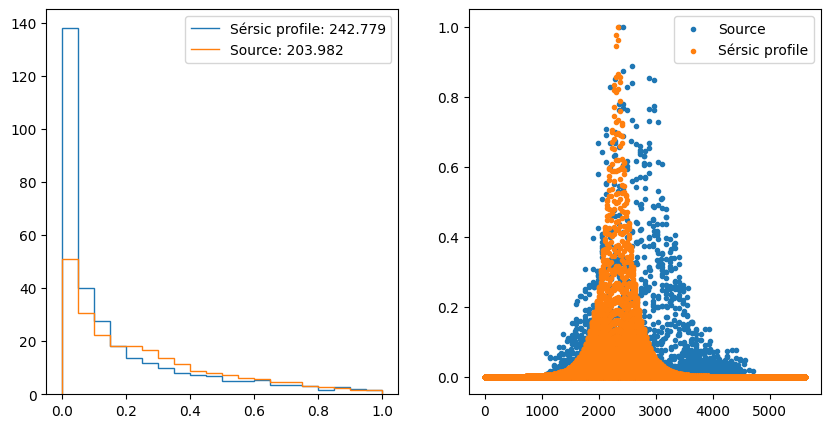

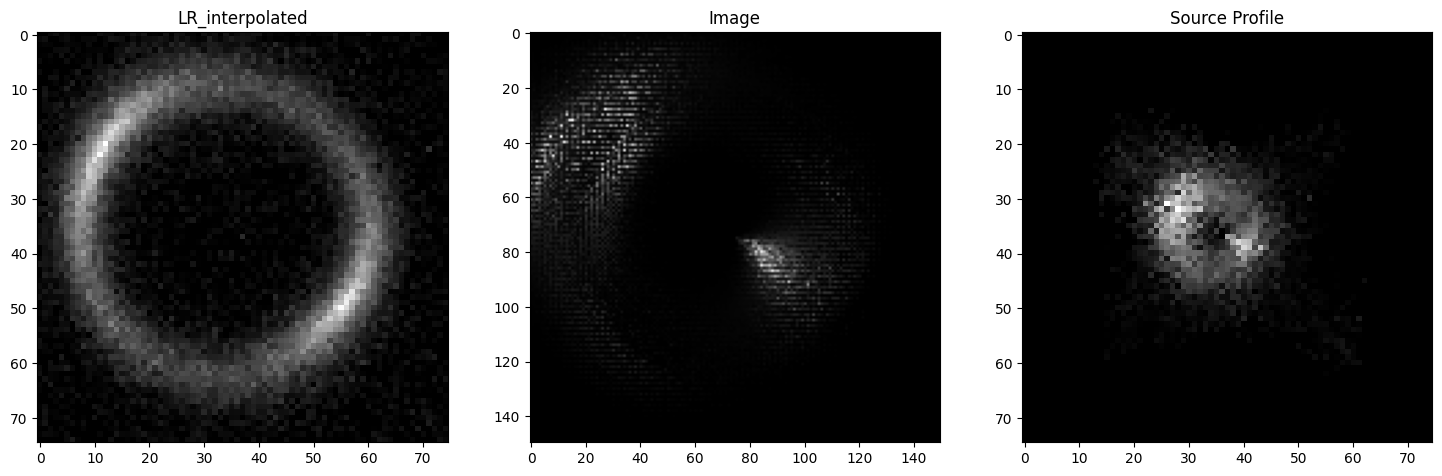

In [9]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required.

In [10]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
best_delta_weights = None
history = {'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[], 'c_loss':[], 'c_val_loss':[], 'accs':[], 'val_accs':[]} # tracks the train and val losses and training results at each epoch
for epoch in range(EPOCHS):
    losses = []
    classifier_losses = []
    accs = []
    alpha_model.train()
    alpha_delta_model.train()
    classifier.train()
    for i,(x, label) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x, label) = (x.float().to(device), label.to(device))
        alpha_r = alpha_model(x)
        alpha_r = alpha_scaling(alpha_r)
        alpha_delta = alpha_delta_model(x)
        alpha_delta = alpha_delta_scaling(alpha_delta)
        loss = lens_loss(alpha_r, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        class_prediction = classifier(alpha_delta)
        classifier_loss = classifier_criterion(class_prediction, label)
        I_lens, _, _ = lens_loss.get_sample(alpha_r.detach() + alpha_delta, x, plot=False)
        LR_interpolated = torch.nn.functional.interpolate(x, scale_factor = 2, mode='bicubic')
        classifier_loss += torch.nn.functional.mse_loss(LR_interpolated, I_lens)
        opt_classifier.zero_grad()
        classifier_loss.backward()
        opt_classifier.step()
        classifier_losses.append(float(classifier_loss))
        prediction_indices = torch.argmax(class_prediction, 1)
        acc = float(torch.sum(label == prediction_indices))/float(len(label))
        accs.append(float(acc))
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} and acc {np.mean(accs)} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses))
    history['c_loss'].append(np.mean(classifier_losses))
    history['accs'].append(np.mean(accs))

    alpha_model.eval()
    alpha_delta_model.eval()
    classifier.eval()
    losses = []
    classifier_losses = []
    accs = []
    for i,(x, label) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x, label) = (x.float().to(device), label.to(device))
        alpha_r = alpha_model(x)
        alpha_r = alpha_scaling(alpha_r)
        alpha_delta = alpha_delta_model(x)
        alpha_delta = alpha_delta_scaling(alpha_delta)
        val_loss = lens_loss(alpha_r, x)
        losses.append(float(val_loss))
        class_prediction = classifier(alpha_delta)
        classifier_loss = classifier_criterion(class_prediction, label)
        I_lens, _, _ = lens_loss.get_sample(alpha_r.detach() + alpha_delta, x, plot=False)
        LR_interpolated = torch.nn.functional.interpolate(x, scale_factor = 2, mode='bicubic')
        classifier_loss += torch.nn.functional.mse_loss(LR_interpolated, I_lens)
        classifier_losses.append(float(classifier_loss))
        prediction_indices = torch.argmax(class_prediction, 1)
        acc = float(torch.sum(label == prediction_indices))/float(len(label))
        accs.append(float(acc))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
        best_delta_weights = alpha_delta_model.state_dict()
    history['val_loss'].append(np.mean(losses))
    history['c_val_loss'].append(np.mean(classifier_losses))
    history['val_accs'].append(np.mean(accs))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} and acc {np.mean(accs)} at LR={opt.param_groups[0]['lr']}")

Training epoch 1: 100%|██████████| 816/816 [01:28<00:00,  9.18it/s]


Training at epoch 1/150: 0.12663682433320025 and acc 0.3438725490196079 at LR=1e-05


Validation epoch 1: 100%|██████████| 204/204 [00:07<00:00, 25.55it/s]


Validation at epoch 1/150: 0.0813112468367406 and acc 0.365686274509804 at LR=1e-05


Training epoch 2: 100%|██████████| 816/816 [01:28<00:00,  9.23it/s]


Training at epoch 2/150: 0.07817946666139453 and acc 0.4004901960784314 at LR=1e-05


Validation epoch 2: 100%|██████████| 204/204 [00:07<00:00, 25.54it/s]


Validation at epoch 2/150: 0.07312499054287579 and acc 0.44901960784313727 at LR=1e-05


Training epoch 3: 100%|██████████| 816/816 [01:28<00:00,  9.22it/s]


Training at epoch 3/150: 0.07048808504352529 and acc 0.6166666666666667 at LR=1e-05


Validation epoch 3: 100%|██████████| 204/204 [00:07<00:00, 25.70it/s]


Validation at epoch 3/150: 0.0646115174955305 and acc 0.7186274509803922 at LR=1e-05


Training epoch 4: 100%|██████████| 816/816 [01:28<00:00,  9.19it/s]


Training at epoch 4/150: 0.05782925417902423 and acc 0.7357843137254901 at LR=1e-05


Validation epoch 4: 100%|██████████| 204/204 [00:07<00:00, 25.56it/s]


Validation at epoch 4/150: 0.048532936648995266 and acc 0.7578431372549019 at LR=1e-05


Training epoch 5: 100%|██████████| 816/816 [01:28<00:00,  9.18it/s]


Training at epoch 5/150: 0.04706026960447358 and acc 0.7727941176470589 at LR=1e-05


Validation epoch 5: 100%|██████████| 204/204 [00:08<00:00, 25.33it/s]


Validation at epoch 5/150: 0.04190860570901457 and acc 0.7794117647058824 at LR=1e-05


Training epoch 6: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 6/150: 0.04203208152880417 and acc 0.7862745098039216 at LR=1e-05


Validation epoch 6: 100%|██████████| 204/204 [00:07<00:00, 25.65it/s]


Validation at epoch 6/150: 0.039128293529810274 and acc 0.7852941176470588 at LR=1e-05


Training epoch 7: 100%|██████████| 816/816 [01:29<00:00,  9.13it/s]


Training at epoch 7/150: 0.038499366195288064 and acc 0.8 at LR=1e-05


Validation epoch 7: 100%|██████████| 204/204 [00:07<00:00, 25.61it/s]


Validation at epoch 7/150: 0.03633895530091489 and acc 0.8274509803921569 at LR=1e-05


Training epoch 8: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 8/150: 0.036274783701325454 and acc 0.7965686274509803 at LR=1e-05


Validation epoch 8: 100%|██████████| 204/204 [00:08<00:00, 25.49it/s]


Validation at epoch 8/150: 0.03267893807816447 and acc 0.803921568627451 at LR=1e-05


Training epoch 9: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 9/150: 0.034929688481212244 and acc 0.7999999999999999 at LR=1e-05


Validation epoch 9: 100%|██████████| 204/204 [00:08<00:00, 25.40it/s]


Validation at epoch 9/150: 0.03248477252382858 and acc 0.8088235294117647 at LR=1e-05


Training epoch 10: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 10/150: 0.03363266073660377 and acc 0.8085784313725489 at LR=1e-05


Validation epoch 10: 100%|██████████| 204/204 [00:08<00:00, 25.41it/s]


Validation at epoch 10/150: 0.030999802299501264 and acc 0.6911764705882352 at LR=1e-05


Training epoch 11: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 11/150: 0.03260166615055984 and acc 0.8161764705882353 at LR=1e-05


Validation epoch 11: 100%|██████████| 204/204 [00:08<00:00, 25.36it/s]


Validation at epoch 11/150: 0.032184157246614206 and acc 0.7450980392156863 at LR=1e-05


Training epoch 12: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 12/150: 0.03163930371759788 and acc 0.8262254901960785 at LR=1e-05


Validation epoch 12: 100%|██████████| 204/204 [00:08<00:00, 25.36it/s]


Validation at epoch 12/150: 0.030282820684506613 and acc 0.8127450980392158 at LR=1e-05


Training epoch 13: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 13/150: 0.030950483402657304 and acc 0.8316176470588235 at LR=1e-05


Validation epoch 13: 100%|██████████| 204/204 [00:08<00:00, 25.30it/s]


Validation at epoch 13/150: 0.029499142512898233 and acc 0.7421568627450981 at LR=1e-05


Training epoch 14: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 14/150: 0.030262788702898166 and acc 0.8401960784313727 at LR=1e-05


Validation epoch 14: 100%|██████████| 204/204 [00:07<00:00, 25.65it/s]


Validation at epoch 14/150: 0.028915865880930248 and acc 0.8029411764705882 at LR=1e-05


Training epoch 15: 100%|██████████| 816/816 [01:29<00:00,  9.14it/s]


Training at epoch 15/150: 0.02973107715347307 and acc 0.8428921568627452 at LR=1e-05


Validation epoch 15: 100%|██████████| 204/204 [00:08<00:00, 25.35it/s]


Validation at epoch 15/150: 0.02813892303418149 and acc 0.8352941176470587 at LR=1e-05


Training epoch 16: 100%|██████████| 816/816 [01:29<00:00,  9.14it/s]


Training at epoch 16/150: 0.029750763415815493 and acc 0.8600490196078431 at LR=1e-05


Validation epoch 16: 100%|██████████| 204/204 [00:07<00:00, 25.56it/s]


Validation at epoch 16/150: 0.028722088487234478 and acc 0.803921568627451 at LR=1e-05


Training epoch 17: 100%|██████████| 816/816 [01:29<00:00,  9.14it/s]


Training at epoch 17/150: 0.028879391762208852 and acc 0.8588235294117647 at LR=1e-05


Validation epoch 17: 100%|██████████| 204/204 [00:08<00:00, 25.25it/s]


Validation at epoch 17/150: 0.02822158299843032 and acc 0.7862745098039214 at LR=1e-05


Training epoch 18: 100%|██████████| 816/816 [01:29<00:00,  9.14it/s]


Training at epoch 18/150: 0.028529708318220562 and acc 0.8620098039215688 at LR=1e-05


Validation epoch 18: 100%|██████████| 204/204 [00:07<00:00, 25.50it/s]


Validation at epoch 18/150: 0.026696572459175016 and acc 0.7411764705882352 at LR=1e-05


Training epoch 19: 100%|██████████| 816/816 [01:29<00:00,  9.13it/s]


Training at epoch 19/150: 0.02796137577616701 and acc 0.8720588235294117 at LR=1e-05


Validation epoch 19: 100%|██████████| 204/204 [00:08<00:00, 25.45it/s]


Validation at epoch 19/150: 0.026746352677982227 and acc 0.8107843137254902 at LR=1e-05


Training epoch 20: 100%|██████████| 816/816 [01:29<00:00,  9.13it/s]


Training at epoch 20/150: 0.027939549278623115 and acc 0.8865196078431372 at LR=1e-05


Validation epoch 20: 100%|██████████| 204/204 [00:08<00:00, 25.28it/s]


Validation at epoch 20/150: 0.02734136906927269 and acc 0.8450980392156865 at LR=1e-05


Training epoch 21: 100%|██████████| 816/816 [01:30<00:00,  9.03it/s]


Training at epoch 21/150: 0.02733830257898708 and acc 0.8877450980392158 at LR=1e-05


Validation epoch 21: 100%|██████████| 204/204 [00:08<00:00, 25.12it/s]


Validation at epoch 21/150: 0.02793098189959339 and acc 0.7911764705882351 at LR=1e-05


Training epoch 22: 100%|██████████| 816/816 [01:29<00:00,  9.09it/s]


Training at epoch 22/150: 0.027150243946451547 and acc 0.8980392156862744 at LR=1e-05


Validation epoch 22: 100%|██████████| 204/204 [00:08<00:00, 25.28it/s]


Validation at epoch 22/150: 0.025944834848975435 and acc 0.8245098039215687 at LR=1e-05


Training epoch 23: 100%|██████████| 816/816 [01:29<00:00,  9.12it/s]


Training at epoch 23/150: 0.026859139847824825 and acc 0.9098039215686274 at LR=1e-05


Validation epoch 23: 100%|██████████| 204/204 [00:08<00:00, 25.39it/s]


Validation at epoch 23/150: 0.026327906190143788 and acc 0.8029411764705882 at LR=1e-05


Training epoch 24: 100%|██████████| 816/816 [01:29<00:00,  9.10it/s]


Training at epoch 24/150: 0.026724531679350298 and acc 0.9161764705882354 at LR=1e-05


Validation epoch 24: 100%|██████████| 204/204 [00:08<00:00, 25.33it/s]


Validation at epoch 24/150: 0.026288588755015357 and acc 0.7715686274509803 at LR=1e-05


Training epoch 25: 100%|██████████| 816/816 [01:29<00:00,  9.13it/s]


Training at epoch 25/150: 0.026034048147837396 and acc 0.9345588235294119 at LR=1e-05


Validation epoch 25: 100%|██████████| 204/204 [00:08<00:00, 25.25it/s]


Validation at epoch 25/150: 0.02525160002394342 and acc 0.7941176470588235 at LR=1e-05


Training epoch 26: 100%|██████████| 816/816 [01:29<00:00,  9.13it/s]


Training at epoch 26/150: 0.025702654159235238 and acc 0.9414215686274511 at LR=1e-05


Validation epoch 26: 100%|██████████| 204/204 [00:08<00:00, 25.18it/s]


Validation at epoch 26/150: 0.024526839715191255 and acc 0.7921568627450979 at LR=1e-05


Training epoch 27: 100%|██████████| 816/816 [01:29<00:00,  9.11it/s]


Training at epoch 27/150: 0.025231152964646324 and acc 0.9455882352941177 at LR=1e-05


Validation epoch 27: 100%|██████████| 204/204 [00:08<00:00, 25.27it/s]


Validation at epoch 27/150: 0.02437820962137159 and acc 0.7960784313725489 at LR=1e-05


Training epoch 28: 100%|██████████| 816/816 [01:29<00:00,  9.13it/s]


Training at epoch 28/150: 0.024949352178202176 and acc 0.9561274509803922 at LR=1e-05


Validation epoch 28: 100%|██████████| 204/204 [00:08<00:00, 25.41it/s]


Validation at epoch 28/150: 0.024642796127819548 and acc 0.7617647058823528 at LR=1e-05


Training epoch 29: 100%|██████████| 816/816 [01:29<00:00,  9.13it/s]


Training at epoch 29/150: 0.024851581128542403 and acc 0.9558823529411765 at LR=1e-05


Validation epoch 29: 100%|██████████| 204/204 [00:08<00:00, 25.30it/s]


Validation at epoch 29/150: 0.025111923642529576 and acc 0.7892156862745098 at LR=1e-05


Training epoch 30: 100%|██████████| 816/816 [01:29<00:00,  9.14it/s]


Training at epoch 30/150: 0.024592966905009804 and acc 0.9561274509803921 at LR=1e-05


Validation epoch 30: 100%|██████████| 204/204 [00:07<00:00, 25.63it/s]


Validation at epoch 30/150: 0.024195989904304344 and acc 0.8058823529411765 at LR=1e-05


Training epoch 31: 100%|██████████| 816/816 [01:29<00:00,  9.13it/s]


Training at epoch 31/150: 0.024447602646735806 and acc 0.9583333333333334 at LR=1e-05


Validation epoch 31: 100%|██████████| 204/204 [00:08<00:00, 25.47it/s]


Validation at epoch 31/150: 0.024031501929914833 and acc 0.8029411764705883 at LR=1e-05


Training epoch 32: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 32/150: 0.024193496026747002 and acc 0.9691176470588235 at LR=1e-05


Validation epoch 32: 100%|██████████| 204/204 [00:07<00:00, 25.60it/s]


Validation at epoch 32/150: 0.023053764936276804 and acc 0.780392156862745 at LR=1e-05


Training epoch 33: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 33/150: 0.023865774886764807 and acc 0.9732843137254903 at LR=1e-05


Validation epoch 33: 100%|██████████| 204/204 [00:07<00:00, 25.58it/s]


Validation at epoch 33/150: 0.022921534442324556 and acc 0.7509803921568627 at LR=1e-05


Training epoch 34: 100%|██████████| 816/816 [01:29<00:00,  9.14it/s]


Training at epoch 34/150: 0.023437254349975026 and acc 0.9674019607843137 at LR=1e-05


Validation epoch 34: 100%|██████████| 204/204 [00:07<00:00, 25.70it/s]


Validation at epoch 34/150: 0.023605122792479748 and acc 0.780392156862745 at LR=1e-05


Training epoch 35: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 35/150: 0.023449448973634372 and acc 0.964950980392157 at LR=1e-05


Validation epoch 35: 100%|██████████| 204/204 [00:07<00:00, 25.64it/s]


Validation at epoch 35/150: 0.02232646264647152 and acc 0.7215686274509804 at LR=1e-05


Training epoch 36: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 36/150: 0.023024906372359277 and acc 0.9789215686274509 at LR=1e-05


Validation epoch 36: 100%|██████████| 204/204 [00:08<00:00, 25.35it/s]


Validation at epoch 36/150: 0.022156298037289697 and acc 0.7401960784313726 at LR=1e-05


Training epoch 37: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 37/150: 0.022920204200964495 and acc 0.9794117647058824 at LR=1e-05


Validation epoch 37: 100%|██████████| 204/204 [00:07<00:00, 25.57it/s]


Validation at epoch 37/150: 0.022263910215092348 and acc 0.7950980392156863 at LR=1e-05


Training epoch 38: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 38/150: 0.022785707043629942 and acc 0.9789215686274509 at LR=1e-05


Validation epoch 38: 100%|██████████| 204/204 [00:07<00:00, 25.56it/s]


Validation at epoch 38/150: 0.021702591297855855 and acc 0.7960784313725489 at LR=1e-05


Training epoch 39: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 39/150: 0.02249175860825013 and acc 0.9823529411764707 at LR=1e-05


Validation epoch 39: 100%|██████████| 204/204 [00:08<00:00, 25.49it/s]


Validation at epoch 39/150: 0.021787852829541352 and acc 0.7862745098039214 at LR=1e-05


Training epoch 40: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 40/150: 0.02217618716360234 and acc 0.9808823529411765 at LR=1e-05


Validation epoch 40: 100%|██████████| 204/204 [00:07<00:00, 25.56it/s]


Validation at epoch 40/150: 0.02171558707349879 and acc 0.7637254901960784 at LR=1e-05


Training epoch 41: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 41/150: 0.021997523447270413 and acc 0.9801470588235294 at LR=1e-05


Validation epoch 41: 100%|██████████| 204/204 [00:07<00:00, 25.51it/s]


Validation at epoch 41/150: 0.02161296120589124 and acc 0.7372549019607844 at LR=1e-05


Training epoch 42: 100%|██████████| 816/816 [01:29<00:00,  9.17it/s]


Training at epoch 42/150: 0.021918693327974966 and acc 0.981127450980392 at LR=1e-05


Validation epoch 42: 100%|██████████| 204/204 [00:07<00:00, 25.54it/s]


Validation at epoch 42/150: 0.02109948747480909 and acc 0.811764705882353 at LR=1e-05


Training epoch 43: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 43/150: 0.021660184171552972 and acc 0.9892156862745098 at LR=1e-05


Validation epoch 43: 100%|██████████| 204/204 [00:07<00:00, 25.56it/s]


Validation at epoch 43/150: 0.021455951035022736 and acc 0.7892156862745098 at LR=1e-05


Training epoch 44: 100%|██████████| 816/816 [01:29<00:00,  9.14it/s]


Training at epoch 44/150: 0.021408329146010253 and acc 0.9838235294117647 at LR=1e-05


Validation epoch 44: 100%|██████████| 204/204 [00:07<00:00, 25.57it/s]


Validation at epoch 44/150: 0.021312126296334992 and acc 0.7941176470588235 at LR=1e-05


Training epoch 45: 100%|██████████| 816/816 [01:28<00:00,  9.17it/s]


Training at epoch 45/150: 0.021199263050220907 and acc 0.986764705882353 at LR=1e-05


Validation epoch 45: 100%|██████████| 204/204 [00:07<00:00, 25.62it/s]


Validation at epoch 45/150: 0.020780864966047162 and acc 0.7627450980392155 at LR=1e-05


Training epoch 46: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 46/150: 0.021063974690988807 and acc 0.9850490196078431 at LR=1e-05


Validation epoch 46: 100%|██████████| 204/204 [00:07<00:00, 25.51it/s]


Validation at epoch 46/150: 0.020700888174092946 and acc 0.7823529411764706 at LR=1e-05


Training epoch 47: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 47/150: 0.021038501419574387 and acc 0.9754901960784313 at LR=1e-05


Validation epoch 47: 100%|██████████| 204/204 [00:07<00:00, 25.58it/s]


Validation at epoch 47/150: 0.020364594531665538 and acc 0.7735294117647058 at LR=1e-05


Training epoch 48: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 48/150: 0.020482605375696485 and acc 0.9977941176470588 at LR=1e-05


Validation epoch 48: 100%|██████████| 204/204 [00:08<00:00, 25.39it/s]


Validation at epoch 48/150: 0.020304165187054406 and acc 0.792156862745098 at LR=1e-05


Training epoch 49: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 49/150: 0.02035084933352967 and acc 0.9928921568627451 at LR=1e-05


Validation epoch 49: 100%|██████████| 204/204 [00:08<00:00, 25.47it/s]


Validation at epoch 49/150: 0.01949538441612294 and acc 0.7715686274509803 at LR=1e-05


Training epoch 50: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 50/150: 0.02028028047689255 and acc 0.9848039215686275 at LR=1e-05


Validation epoch 50: 100%|██████████| 204/204 [00:07<00:00, 25.51it/s]


Validation at epoch 50/150: 0.019503452221625577 and acc 0.7960784313725489 at LR=1e-05


Training epoch 51: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 51/150: 0.019958070491887994 and acc 0.9850490196078431 at LR=1e-05


Validation epoch 51: 100%|██████████| 204/204 [00:08<00:00, 25.38it/s]


Validation at epoch 51/150: 0.02019949425377098 and acc 0.7627450980392156 at LR=1e-05


Training epoch 52: 100%|██████████| 816/816 [01:28<00:00,  9.17it/s]


Training at epoch 52/150: 0.01984842837897732 and acc 0.9867647058823529 at LR=1e-05


Validation epoch 52: 100%|██████████| 204/204 [00:07<00:00, 25.53it/s]


Validation at epoch 52/150: 0.01954522216692567 and acc 0.7284313725490196 at LR=1e-05


Training epoch 53: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 53/150: 0.01953013088581536 and acc 0.9897058823529412 at LR=1e-05


Validation epoch 53: 100%|██████████| 204/204 [00:07<00:00, 25.60it/s]


Validation at epoch 53/150: 0.01906295162716917 and acc 0.807843137254902 at LR=1e-05


Training epoch 54: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 54/150: 0.019191330259976287 and acc 0.9848039215686275 at LR=1e-05


Validation epoch 54: 100%|██████████| 204/204 [00:07<00:00, 25.53it/s]


Validation at epoch 54/150: 0.01896826268228538 and acc 0.7676470588235292 at LR=1e-05


Training epoch 55: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 55/150: 0.01897772775355763 and acc 0.9941176470588236 at LR=1e-05


Validation epoch 55: 100%|██████████| 204/204 [00:07<00:00, 25.59it/s]


Validation at epoch 55/150: 0.0184809862015148 and acc 0.7205882352941175 at LR=1e-05


Training epoch 56: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 56/150: 0.018710685368882967 and acc 0.9806372549019609 at LR=1e-05


Validation epoch 56: 100%|██████████| 204/204 [00:07<00:00, 25.68it/s]


Validation at epoch 56/150: 0.01837838382697573 and acc 0.734313725490196 at LR=1e-05


Training epoch 57: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 57/150: 0.019107728254953948 and acc 0.9909313725490196 at LR=1e-05


Validation epoch 57: 100%|██████████| 204/204 [00:07<00:00, 25.55it/s]


Validation at epoch 57/150: 0.018886466099716285 and acc 0.7745098039215687 at LR=1e-05


Training epoch 58: 100%|██████████| 816/816 [01:28<00:00,  9.18it/s]


Training at epoch 58/150: 0.018522934538458345 and acc 0.9985294117647058 at LR=1e-05


Validation epoch 58: 100%|██████████| 204/204 [00:08<00:00, 25.46it/s]


Validation at epoch 58/150: 0.01906629182471364 and acc 0.7931372549019609 at LR=1e-05


Training epoch 59: 100%|██████████| 816/816 [01:28<00:00,  9.17it/s]


Training at epoch 59/150: 0.018262277786419086 and acc 0.9772058823529411 at LR=1e-05


Validation epoch 59: 100%|██████████| 204/204 [00:07<00:00, 25.52it/s]


Validation at epoch 59/150: 0.0178704968306656 and acc 0.7784313725490196 at LR=1e-05


Training epoch 60: 100%|██████████| 816/816 [01:28<00:00,  9.17it/s]


Training at epoch 60/150: 0.01800271333195269 and acc 0.9938725490196079 at LR=1e-05


Validation epoch 60: 100%|██████████| 204/204 [00:07<00:00, 25.54it/s]


Validation at epoch 60/150: 0.01752466611637204 and acc 0.6911764705882353 at LR=1e-05


Training epoch 61: 100%|██████████| 816/816 [01:28<00:00,  9.18it/s]


Training at epoch 61/150: 0.01789972123429727 and acc 0.9958333333333333 at LR=1e-05


Validation epoch 61: 100%|██████████| 204/204 [00:08<00:00, 25.39it/s]


Validation at epoch 61/150: 0.017323858396825837 and acc 0.7147058823529411 at LR=1e-05


Training epoch 62: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 62/150: 0.017589825866333043 and acc 0.9872549019607844 at LR=1e-05


Validation epoch 62: 100%|██████████| 204/204 [00:07<00:00, 25.50it/s]


Validation at epoch 62/150: 0.01680141149600055 and acc 0.8009803921568627 at LR=1e-05


Training epoch 63: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 63/150: 0.017354069331286512 and acc 0.991421568627451 at LR=1e-05


Validation epoch 63: 100%|██████████| 204/204 [00:07<00:00, 25.58it/s]


Validation at epoch 63/150: 0.01738637027915056 and acc 0.7990196078431373 at LR=1e-05


Training epoch 64: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 64/150: 0.01711560988013505 and acc 0.9943627450980392 at LR=1e-05


Validation epoch 64: 100%|██████████| 204/204 [00:07<00:00, 25.57it/s]


Validation at epoch 64/150: 0.016702891569401995 and acc 0.7284313725490196 at LR=1e-05


Training epoch 65: 100%|██████████| 816/816 [01:28<00:00,  9.17it/s]


Training at epoch 65/150: 0.016852218023154373 and acc 0.9948529411764707 at LR=1e-05


Validation epoch 65: 100%|██████████| 204/204 [00:08<00:00, 25.50it/s]


Validation at epoch 65/150: 0.01668894588125541 and acc 0.7823529411764705 at LR=1e-05


Training epoch 66: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 66/150: 0.01667438632484489 and acc 0.9874999999999999 at LR=1e-05


Validation epoch 66: 100%|██████████| 204/204 [00:07<00:00, 25.58it/s]


Validation at epoch 66/150: 0.01639615851637049 and acc 0.7843137254901961 at LR=1e-05


Training epoch 67: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 67/150: 0.01644856426248546 and acc 0.9821078431372549 at LR=1e-05


Validation epoch 67: 100%|██████████| 204/204 [00:07<00:00, 25.59it/s]


Validation at epoch 67/150: 0.01600477561427682 and acc 0.768627450980392 at LR=1e-05


Training epoch 68: 100%|██████████| 816/816 [01:29<00:00,  9.17it/s]


Training at epoch 68/150: 0.01621038756817214 and acc 0.9985294117647058 at LR=1e-05


Validation epoch 68: 100%|██████████| 204/204 [00:07<00:00, 25.67it/s]


Validation at epoch 68/150: 0.01633416711553639 and acc 0.7656862745098039 at LR=1e-05


Training epoch 69: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 69/150: 0.01596162485314862 and acc 1.0 at LR=1e-05


Validation epoch 69: 100%|██████████| 204/204 [00:07<00:00, 25.54it/s]


Validation at epoch 69/150: 0.016057028663435988 and acc 0.7990196078431371 at LR=1e-05


Training epoch 70: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 70/150: 0.015747854232733303 and acc 1.0 at LR=1e-05


Validation epoch 70: 100%|██████████| 204/204 [00:07<00:00, 25.61it/s]


Validation at epoch 70/150: 0.015111658475635684 and acc 0.7980392156862746 at LR=1e-05


Training epoch 71: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 71/150: 0.015627582945550483 and acc 0.9772058823529413 at LR=1e-05


Validation epoch 71: 100%|██████████| 204/204 [00:07<00:00, 25.63it/s]


Validation at epoch 71/150: 0.015143495532410109 and acc 0.7686274509803922 at LR=1e-05


Training epoch 72: 100%|██████████| 816/816 [01:29<00:00,  9.14it/s]


Training at epoch 72/150: 0.015403557520852807 and acc 0.9860294117647059 at LR=1e-05


Validation epoch 72: 100%|██████████| 204/204 [00:08<00:00, 25.47it/s]


Validation at epoch 72/150: 0.01492823809659218 and acc 0.7872549019607842 at LR=1e-05


Training epoch 73: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 73/150: 0.01504412887266417 and acc 0.9924019607843136 at LR=1e-05


Validation epoch 73: 100%|██████████| 204/204 [00:08<00:00, 25.48it/s]


Validation at epoch 73/150: 0.014600683542370213 and acc 0.7588235294117647 at LR=1e-05


Training epoch 74: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 74/150: 0.015081316399885634 and acc 0.9928921568627451 at LR=1e-05


Validation epoch 74: 100%|██████████| 204/204 [00:07<00:00, 25.65it/s]


Validation at epoch 74/150: 0.015037179892590525 and acc 0.803921568627451 at LR=1e-05


Training epoch 75: 100%|██████████| 816/816 [01:29<00:00,  9.17it/s]


Training at epoch 75/150: 0.01472978854172991 and acc 0.9948529411764705 at LR=1e-05


Validation epoch 75: 100%|██████████| 204/204 [00:07<00:00, 25.58it/s]


Validation at epoch 75/150: 0.014168760517849495 and acc 0.7205882352941176 at LR=1e-05


Training epoch 76: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 76/150: 0.01453837087291165 and acc 0.9950980392156863 at LR=1e-05


Validation epoch 76: 100%|██████████| 204/204 [00:07<00:00, 25.52it/s]


Validation at epoch 76/150: 0.013933886262569941 and acc 0.7901960784313725 at LR=1e-05


Training epoch 77: 100%|██████████| 816/816 [01:28<00:00,  9.17it/s]


Training at epoch 77/150: 0.01429148112291324 and acc 0.9828431372549019 at LR=1e-05


Validation epoch 77: 100%|██████████| 204/204 [00:08<00:00, 25.46it/s]


Validation at epoch 77/150: 0.014265449402634712 and acc 0.7833333333333332 at LR=1e-05


Training epoch 78: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 78/150: 0.014429995061957515 and acc 1.0 at LR=1e-05


Validation epoch 78: 100%|██████████| 204/204 [00:08<00:00, 25.45it/s]


Validation at epoch 78/150: 0.014131157811931973 and acc 0.7852941176470588 at LR=1e-05


Training epoch 79: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 79/150: 0.013891972666469347 and acc 1.0 at LR=1e-05


Validation epoch 79: 100%|██████████| 204/204 [00:08<00:00, 25.36it/s]


Validation at epoch 79/150: 0.013262539467427368 and acc 0.7843137254901961 at LR=1e-05


Training epoch 80: 100%|██████████| 816/816 [01:29<00:00,  9.14it/s]


Training at epoch 80/150: 0.013614563913399573 and acc 0.9830882352941177 at LR=1e-05


Validation epoch 80: 100%|██████████| 204/204 [00:07<00:00, 25.50it/s]


Validation at epoch 80/150: 0.01307022960071324 and acc 0.75 at LR=1e-05


Training epoch 81: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 81/150: 0.014009083088204338 and acc 0.9931372549019608 at LR=1e-05


Validation epoch 81: 100%|██████████| 204/204 [00:08<00:00, 25.47it/s]


Validation at epoch 81/150: 0.01373611415243324 and acc 0.7833333333333334 at LR=1e-05


Training epoch 82: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 82/150: 0.013493422789763952 and acc 1.0 at LR=1e-05


Validation epoch 82: 100%|██████████| 204/204 [00:07<00:00, 25.57it/s]


Validation at epoch 82/150: 0.014018031156749702 and acc 0.7852941176470588 at LR=1e-05


Training epoch 83: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 83/150: 0.013183467777208517 and acc 0.9904411764705883 at LR=1e-05


Validation epoch 83: 100%|██████████| 204/204 [00:08<00:00, 25.47it/s]


Validation at epoch 83/150: 0.012848027244520685 and acc 0.7823529411764706 at LR=1e-05


Training epoch 84: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 84/150: 0.012862220593709863 and acc 0.9899509803921568 at LR=1e-05


Validation epoch 84: 100%|██████████| 204/204 [00:07<00:00, 25.58it/s]


Validation at epoch 84/150: 0.012721422475342657 and acc 0.7705882352941176 at LR=1e-05


Training epoch 85: 100%|██████████| 816/816 [01:29<00:00,  9.17it/s]


Training at epoch 85/150: 0.012693815150152088 and acc 0.9950980392156863 at LR=1e-05


Validation epoch 85: 100%|██████████| 204/204 [00:08<00:00, 25.36it/s]


Validation at epoch 85/150: 0.012156746815890074 and acc 0.7833333333333334 at LR=1e-05


Training epoch 86: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 86/150: 0.012465586757410647 and acc 0.9894607843137254 at LR=1e-05


Validation epoch 86: 100%|██████████| 204/204 [00:07<00:00, 25.58it/s]


Validation at epoch 86/150: 0.012559469131862415 and acc 0.7882352941176469 at LR=1e-05


Training epoch 87: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 87/150: 0.01257239408647258 and acc 0.9928921568627451 at LR=1e-05


Validation epoch 87: 100%|██████████| 204/204 [00:08<00:00, 25.42it/s]


Validation at epoch 87/150: 0.011936361424387525 and acc 0.7147058823529411 at LR=1e-05


Training epoch 88: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 88/150: 0.01221202366686353 and acc 0.9968137254901961 at LR=1e-05


Validation epoch 88: 100%|██████████| 204/204 [00:07<00:00, 25.71it/s]


Validation at epoch 88/150: 0.01219866604672051 and acc 0.7862745098039214 at LR=1e-05


Training epoch 89: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 89/150: 0.011814687728617048 and acc 1.0 at LR=1e-05


Validation epoch 89: 100%|██████████| 204/204 [00:08<00:00, 25.44it/s]


Validation at epoch 89/150: 0.011624735517555154 and acc 0.7813725490196077 at LR=1e-05


Training epoch 90: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 90/150: 0.011621219287489486 and acc 0.9924019607843136 at LR=1e-05


Validation epoch 90: 100%|██████████| 204/204 [00:07<00:00, 25.61it/s]


Validation at epoch 90/150: 0.011237236929089562 and acc 0.7647058823529411 at LR=1e-05


Training epoch 91: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 91/150: 0.01153619639294715 and acc 0.9916666666666667 at LR=1e-05


Validation epoch 91: 100%|██████████| 204/204 [00:07<00:00, 25.50it/s]


Validation at epoch 91/150: 0.011445627367470925 and acc 0.7931372549019609 at LR=1e-05


Training epoch 92: 100%|██████████| 816/816 [01:28<00:00,  9.18it/s]


Training at epoch 92/150: 0.011292268935814682 and acc 0.9997549019607842 at LR=1e-05


Validation epoch 92: 100%|██████████| 204/204 [00:08<00:00, 25.48it/s]


Validation at epoch 92/150: 0.010977245609312519 and acc 0.7921568627450979 at LR=1e-05


Training epoch 93: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 93/150: 0.011276263696273934 and acc 1.0 at LR=1e-05


Validation epoch 93: 100%|██████████| 204/204 [00:08<00:00, 25.37it/s]


Validation at epoch 93/150: 0.011314177068461682 and acc 0.7813725490196078 at LR=1e-05


Training epoch 94: 100%|██████████| 816/816 [01:28<00:00,  9.17it/s]


Training at epoch 94/150: 0.010936469465092408 and acc 1.0 at LR=1e-05


Validation epoch 94: 100%|██████████| 204/204 [00:08<00:00, 25.35it/s]


Validation at epoch 94/150: 0.010916367150368351 and acc 0.7794117647058824 at LR=1e-05


Training epoch 95: 100%|██████████| 816/816 [01:29<00:00,  9.17it/s]


Training at epoch 95/150: 0.010808904122278168 and acc 1.0 at LR=1e-05


Validation epoch 95: 100%|██████████| 204/204 [00:08<00:00, 25.26it/s]


Validation at epoch 95/150: 0.010175731733861361 and acc 0.7862745098039216 at LR=1e-05


Training epoch 96: 100%|██████████| 816/816 [01:29<00:00,  9.14it/s]


Training at epoch 96/150: 0.010498945863218978 and acc 0.9838235294117647 at LR=1e-05


Validation epoch 96: 100%|██████████| 204/204 [00:07<00:00, 25.50it/s]


Validation at epoch 96/150: 0.010406644076711553 and acc 0.7735294117647059 at LR=1e-05


Training epoch 97: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 97/150: 0.01027018392650301 and acc 0.9943627450980392 at LR=1e-05


Validation epoch 97: 100%|██████████| 204/204 [00:07<00:00, 25.54it/s]


Validation at epoch 97/150: 0.009954411461127593 and acc 0.7607843137254902 at LR=1e-05


Training epoch 98: 100%|██████████| 816/816 [01:28<00:00,  9.17it/s]


Training at epoch 98/150: 0.010243118877577432 and acc 0.9906862745098038 at LR=1e-05


Validation epoch 98: 100%|██████████| 204/204 [00:07<00:00, 25.59it/s]


Validation at epoch 98/150: 0.010236022352496637 and acc 0.7696078431372549 at LR=1e-05


Training epoch 99: 100%|██████████| 816/816 [01:29<00:00,  9.14it/s]


Training at epoch 99/150: 0.009880855443828064 and acc 0.9997549019607842 at LR=1e-05


Validation epoch 99: 100%|██████████| 204/204 [00:08<00:00, 25.41it/s]


Validation at epoch 99/150: 0.009743725965438666 and acc 0.7666666666666666 at LR=1e-05


Training epoch 100: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 100/150: 0.009727208745008445 and acc 0.9904411764705883 at LR=1e-05


Validation epoch 100: 100%|██████████| 204/204 [00:08<00:00, 25.40it/s]


Validation at epoch 100/150: 0.009434468838769723 and acc 0.7745098039215687 at LR=1e-05


Training epoch 101: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 101/150: 0.009601320272457659 and acc 1.0 at LR=1e-05


Validation epoch 101: 100%|██████████| 204/204 [00:08<00:00, 25.47it/s]


Validation at epoch 101/150: 0.00952965345726732 and acc 0.7833333333333332 at LR=1e-05


Training epoch 102: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 102/150: 0.009532673713550264 and acc 0.9872549019607844 at LR=1e-05


Validation epoch 102: 100%|██████████| 204/204 [00:08<00:00, 25.39it/s]


Validation at epoch 102/150: 0.009456990177140516 and acc 0.7745098039215687 at LR=1e-05


Training epoch 103: 100%|██████████| 816/816 [01:29<00:00,  9.17it/s]


Training at epoch 103/150: 0.009286510431682509 and acc 0.9985294117647058 at LR=1e-05


Validation epoch 103: 100%|██████████| 204/204 [00:08<00:00, 25.50it/s]


Validation at epoch 103/150: 0.009145527452632201 and acc 0.780392156862745 at LR=1e-05


Training epoch 104: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 104/150: 0.009300228461677976 and acc 1.0 at LR=1e-05


Validation epoch 104: 100%|██████████| 204/204 [00:07<00:00, 25.55it/s]


Validation at epoch 104/150: 0.008859316307101763 and acc 0.7588235294117648 at LR=1e-05


Training epoch 105: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 105/150: 0.008966285060273995 and acc 0.9894607843137254 at LR=1e-05


Validation epoch 105: 100%|██████████| 204/204 [00:07<00:00, 25.64it/s]


Validation at epoch 105/150: 0.008601379859279477 and acc 0.777450980392157 at LR=1e-05


Training epoch 106: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 106/150: 0.008667184001715927 and acc 0.9955882352941178 at LR=1e-05


Validation epoch 106: 100%|██████████| 204/204 [00:07<00:00, 25.55it/s]


Validation at epoch 106/150: 0.008862899643752505 and acc 0.7666666666666666 at LR=1e-05


Training epoch 107: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 107/150: 0.00857127991084959 and acc 1.0 at LR=1e-05


Validation epoch 107: 100%|██████████| 204/204 [00:08<00:00, 25.31it/s]


Validation at epoch 107/150: 0.009161110211839425 and acc 0.7813725490196078 at LR=1e-05


Training epoch 108: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 108/150: 0.008295482751575536 and acc 1.0 at LR=1e-05


Validation epoch 108: 100%|██████████| 204/204 [00:07<00:00, 25.56it/s]


Validation at epoch 108/150: 0.00803282938888479 and acc 0.7774509803921569 at LR=1e-05


Training epoch 109: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 109/150: 0.00845131646686544 and acc 0.9879901960784314 at LR=1e-05


Validation epoch 109: 100%|██████████| 204/204 [00:07<00:00, 25.65it/s]


Validation at epoch 109/150: 0.008399299590154459 and acc 0.7696078431372549 at LR=1e-05


Training epoch 110: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 110/150: 0.008009905232956596 and acc 0.9982843137254901 at LR=1e-05


Validation epoch 110: 100%|██████████| 204/204 [00:08<00:00, 25.45it/s]


Validation at epoch 110/150: 0.00794024131598645 and acc 0.776470588235294 at LR=1e-05


Training epoch 111: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 111/150: 0.007825934220283456 and acc 0.9933823529411765 at LR=1e-05


Validation epoch 111: 100%|██████████| 204/204 [00:08<00:00, 25.28it/s]


Validation at epoch 111/150: 0.0075598060445604374 and acc 0.7715686274509803 at LR=1e-05


Training epoch 112: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 112/150: 0.007783149087153302 and acc 0.9931372549019608 at LR=1e-05


Validation epoch 112: 100%|██████████| 204/204 [00:07<00:00, 25.60it/s]


Validation at epoch 112/150: 0.008006014114738825 and acc 0.668627450980392 at LR=1e-05


Training epoch 113: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 113/150: 0.007843983286589968 and acc 0.9933823529411765 at LR=1e-05


Validation epoch 113: 100%|██████████| 204/204 [00:08<00:00, 25.40it/s]


Validation at epoch 113/150: 0.007595510425173915 and acc 0.7735294117647058 at LR=1e-05


Training epoch 114: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 114/150: 0.007889383172903977 and acc 0.9970588235294118 at LR=1e-05


Validation epoch 114: 100%|██████████| 204/204 [00:07<00:00, 25.60it/s]


Validation at epoch 114/150: 0.007715131169842447 and acc 0.780392156862745 at LR=1e-05


Training epoch 115: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 115/150: 0.007519712159752517 and acc 0.9990196078431373 at LR=1e-05


Validation epoch 115: 100%|██████████| 204/204 [00:07<00:00, 25.64it/s]


Validation at epoch 115/150: 0.007524753724425739 and acc 0.7784313725490196 at LR=1e-05


Training epoch 116: 100%|██████████| 816/816 [01:29<00:00,  9.14it/s]


Training at epoch 116/150: 0.007260967673181428 and acc 0.9882352941176472 at LR=1e-05


Validation epoch 116: 100%|██████████| 204/204 [00:07<00:00, 25.66it/s]


Validation at epoch 116/150: 0.007140649252059851 and acc 0.7725490196078433 at LR=1e-05


Training epoch 117: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 117/150: 0.007070507126056827 and acc 0.9977941176470588 at LR=1e-05


Validation epoch 117: 100%|██████████| 204/204 [00:08<00:00, 25.29it/s]


Validation at epoch 117/150: 0.007231829790672397 and acc 0.7725490196078431 at LR=1e-05


Training epoch 118: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 118/150: 0.007021935246645144 and acc 0.9948529411764705 at LR=1e-05


Validation epoch 118: 100%|██████████| 204/204 [00:08<00:00, 25.39it/s]


Validation at epoch 118/150: 0.006861299591358094 and acc 0.742156862745098 at LR=1e-05


Training epoch 119: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 119/150: 0.006730973577028706 and acc 0.999264705882353 at LR=1e-05


Validation epoch 119: 100%|██████████| 204/204 [00:07<00:00, 25.54it/s]


Validation at epoch 119/150: 0.006866255442967967 and acc 0.7186274509803922 at LR=1e-05


Training epoch 120: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 120/150: 0.006682866703212152 and acc 0.9901960784313726 at LR=1e-05


Validation epoch 120: 100%|██████████| 204/204 [00:07<00:00, 25.55it/s]


Validation at epoch 120/150: 0.006884613723777162 and acc 0.7715686274509803 at LR=1e-05


Training epoch 121: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 121/150: 0.006614822398999012 and acc 0.9997549019607842 at LR=1e-05


Validation epoch 121: 100%|██████████| 204/204 [00:07<00:00, 25.64it/s]


Validation at epoch 121/150: 0.0069213823059245064 and acc 0.7764705882352941 at LR=1e-05


Training epoch 122: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 122/150: 0.006753792506060563 and acc 1.0 at LR=1e-05


Validation epoch 122: 100%|██████████| 204/204 [00:07<00:00, 25.57it/s]


Validation at epoch 122/150: 0.00799999754720678 and acc 0.7735294117647058 at LR=1e-05


Training epoch 123: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 123/150: 0.006762454767286887 and acc 0.9887254901960784 at LR=1e-05


Validation epoch 123: 100%|██████████| 204/204 [00:07<00:00, 25.55it/s]


Validation at epoch 123/150: 0.006562402331516804 and acc 0.776470588235294 at LR=1e-05


Training epoch 124: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 124/150: 0.006251734482265972 and acc 0.9980392156862746 at LR=1e-05


Validation epoch 124: 100%|██████████| 204/204 [00:08<00:00, 25.32it/s]


Validation at epoch 124/150: 0.006442291989657736 and acc 0.7568627450980394 at LR=1e-05


Training epoch 125: 100%|██████████| 816/816 [01:29<00:00,  9.15it/s]


Training at epoch 125/150: 0.0061028284270672455 and acc 1.0 at LR=1e-05


Validation epoch 125: 100%|██████████| 204/204 [00:08<00:00, 25.45it/s]


Validation at epoch 125/150: 0.006295179146999384 and acc 0.7794117647058824 at LR=1e-05


Training epoch 126: 100%|██████████| 816/816 [01:28<00:00,  9.17it/s]


Training at epoch 126/150: 0.006085866687570552 and acc 1.0 at LR=1e-05


Validation epoch 126: 100%|██████████| 204/204 [00:08<00:00, 25.43it/s]


Validation at epoch 126/150: 0.006125113609539089 and acc 0.7843137254901961 at LR=1e-05


Training epoch 127: 100%|██████████| 816/816 [01:28<00:00,  9.18it/s]


Training at epoch 127/150: 0.006095572076589509 and acc 1.0 at LR=1e-05


Validation epoch 127: 100%|██████████| 204/204 [00:08<00:00, 25.43it/s]


Validation at epoch 127/150: 0.00603768646411196 and acc 0.7862745098039214 at LR=1e-05


Training epoch 128: 100%|██████████| 816/816 [01:29<00:00,  9.17it/s]


Training at epoch 128/150: 0.005961560203657285 and acc 0.9835784313725491 at LR=1e-05


Validation epoch 128: 100%|██████████| 204/204 [00:08<00:00, 25.48it/s]


Validation at epoch 128/150: 0.005986023493403313 and acc 0.7725490196078431 at LR=1e-05


Training epoch 129: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 129/150: 0.005791192997005019 and acc 0.9977941176470588 at LR=1e-05


Validation epoch 129: 100%|██████████| 204/204 [00:07<00:00, 25.64it/s]


Validation at epoch 129/150: 0.006093550935688922 and acc 0.7460784313725489 at LR=1e-05


Training epoch 130: 100%|██████████| 816/816 [01:28<00:00,  9.18it/s]


Training at epoch 130/150: 0.005688204373833358 and acc 0.991421568627451 at LR=1e-05


Validation epoch 130: 100%|██████████| 204/204 [00:07<00:00, 25.56it/s]


Validation at epoch 130/150: 0.005728928415634322 and acc 0.7813725490196077 at LR=1e-05


Training epoch 131: 100%|██████████| 816/816 [01:28<00:00,  9.18it/s]


Training at epoch 131/150: 0.005630933273898657 and acc 0.9995098039215686 at LR=1e-05


Validation epoch 131: 100%|██████████| 204/204 [00:08<00:00, 25.33it/s]


Validation at epoch 131/150: 0.005736688783109261 and acc 0.7872549019607843 at LR=1e-05


Training epoch 132: 100%|██████████| 816/816 [01:29<00:00,  9.17it/s]


Training at epoch 132/150: 0.0056416407765651705 and acc 0.9965686274509804 at LR=1e-05


Validation epoch 132: 100%|██████████| 204/204 [00:07<00:00, 25.60it/s]


Validation at epoch 132/150: 0.006038563208444519 and acc 0.7372549019607842 at LR=1e-05


Training epoch 133: 100%|██████████| 816/816 [01:29<00:00,  9.17it/s]


Training at epoch 133/150: 0.005521778101455329 and acc 0.9936274509803921 at LR=1e-05


Validation epoch 133: 100%|██████████| 204/204 [00:07<00:00, 25.60it/s]


Validation at epoch 133/150: 0.00540027801887881 and acc 0.6647058823529411 at LR=1e-05


Training epoch 134: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 134/150: 0.005756751455277588 and acc 0.9992647058823529 at LR=1e-05


Validation epoch 134: 100%|██████████| 204/204 [00:08<00:00, 25.49it/s]


Validation at epoch 134/150: 0.007380225236856323 and acc 0.7813725490196078 at LR=1e-05


Training epoch 135: 100%|██████████| 816/816 [01:28<00:00,  9.18it/s]


Training at epoch 135/150: 0.00836585278339757 and acc 0.9919117647058825 at LR=1e-05


Validation epoch 135: 100%|██████████| 204/204 [00:07<00:00, 25.59it/s]


Validation at epoch 135/150: 0.005818269879776327 and acc 0.7558823529411764 at LR=1e-05


Training epoch 136: 100%|██████████| 816/816 [01:29<00:00,  9.17it/s]


Training at epoch 136/150: 0.005263160748404962 and acc 0.9980392156862746 at LR=1e-05


Validation epoch 136: 100%|██████████| 204/204 [00:07<00:00, 25.51it/s]


Validation at epoch 136/150: 0.0056498975449643446 and acc 0.7539215686274511 at LR=1e-05


Training epoch 137: 100%|██████████| 816/816 [01:28<00:00,  9.19it/s]


Training at epoch 137/150: 0.005212987502340647 and acc 0.9931372549019608 at LR=1e-05


Validation epoch 137: 100%|██████████| 204/204 [00:07<00:00, 25.55it/s]


Validation at epoch 137/150: 0.00533866513561567 and acc 0.7676470588235292 at LR=1e-05


Training epoch 138: 100%|██████████| 816/816 [01:29<00:00,  9.16it/s]


Training at epoch 138/150: 0.005303995128533821 and acc 0.9958333333333333 at LR=1e-05


Validation epoch 138: 100%|██████████| 204/204 [00:07<00:00, 25.67it/s]


Validation at epoch 138/150: 0.005656608706796724 and acc 0.7598039215686274 at LR=1e-05


Training epoch 139: 100%|██████████| 816/816 [01:28<00:00,  9.18it/s]


Training at epoch 139/150: 0.0051888900662900184 and acc 0.9968137254901961 at LR=1e-05


Validation epoch 139: 100%|██████████| 204/204 [00:08<00:00, 25.46it/s]


Validation at epoch 139/150: 0.005283530362123879 and acc 0.7627450980392156 at LR=1e-05


Training epoch 140: 100%|██████████| 816/816 [01:28<00:00,  9.18it/s]


Training at epoch 140/150: 0.005222749502875148 and acc 0.9943627450980392 at LR=1e-05


Validation epoch 140: 100%|██████████| 204/204 [00:07<00:00, 25.67it/s]


Validation at epoch 140/150: 0.005679180268106945 and acc 0.7578431372549018 at LR=1e-05


Training epoch 141: 100%|██████████| 816/816 [01:28<00:00,  9.17it/s]


Training at epoch 141/150: 0.005180683425244163 and acc 0.9995098039215686 at LR=1e-05


Validation epoch 141: 100%|██████████| 204/204 [00:07<00:00, 25.53it/s]


Validation at epoch 141/150: 0.005450416207952681 and acc 0.7745098039215687 at LR=1e-05


Training epoch 142: 100%|██████████| 816/816 [01:28<00:00,  9.19it/s]


Training at epoch 142/150: 0.005091219100137881 and acc 1.0 at LR=1e-05


Validation epoch 142: 100%|██████████| 204/204 [00:08<00:00, 25.38it/s]


Validation at epoch 142/150: 0.00537350729870263 and acc 0.7696078431372549 at LR=1e-05


Training epoch 143: 100%|██████████| 816/816 [01:28<00:00,  9.18it/s]


Training at epoch 143/150: 0.005058850564904895 and acc 1.0 at LR=1e-05


Validation epoch 143: 100%|██████████| 204/204 [00:07<00:00, 25.64it/s]


Validation at epoch 143/150: 0.005378081907253421 and acc 0.7627450980392155 at LR=1e-05


Training epoch 144: 100%|██████████| 816/816 [01:28<00:00,  9.17it/s]


Training at epoch 144/150: 0.005339890229972262 and acc 1.0 at LR=1e-05


Validation epoch 144: 100%|██████████| 204/204 [00:07<00:00, 25.52it/s]


Validation at epoch 144/150: 0.005307906188582089 and acc 0.7745098039215687 at LR=1e-05


Training epoch 145: 100%|██████████| 816/816 [01:28<00:00,  9.18it/s]


Training at epoch 145/150: 0.005183383026080407 and acc 0.9904411764705883 at LR=1e-05


Validation epoch 145: 100%|██████████| 204/204 [00:07<00:00, 25.55it/s]


Validation at epoch 145/150: 0.005058070301196958 and acc 0.7598039215686274 at LR=1e-05


Training epoch 146: 100%|██████████| 816/816 [01:28<00:00,  9.18it/s]


Training at epoch 146/150: 0.005028439681422349 and acc 0.9958333333333333 at LR=1e-05


Validation epoch 146: 100%|██████████| 204/204 [00:07<00:00, 25.57it/s]


Validation at epoch 146/150: 0.005049802352646913 and acc 0.7705882352941176 at LR=1e-05


Training epoch 147: 100%|██████████| 816/816 [01:28<00:00,  9.18it/s]


Training at epoch 147/150: 0.005244483232530126 and acc 0.9975490196078431 at LR=1e-05


Validation epoch 147: 100%|██████████| 204/204 [00:07<00:00, 25.61it/s]


Validation at epoch 147/150: 0.004853933368234292 and acc 0.7754901960784313 at LR=1e-05


Training epoch 148: 100%|██████████| 816/816 [01:28<00:00,  9.17it/s]


Training at epoch 148/150: 0.005057718496377051 and acc 1.0 at LR=1e-05


Validation epoch 148: 100%|██████████| 204/204 [00:07<00:00, 25.65it/s]


Validation at epoch 148/150: 0.0051767828865159375 and acc 0.7774509803921569 at LR=1e-05


Training epoch 149: 100%|██████████| 816/816 [01:28<00:00,  9.17it/s]


Training at epoch 149/150: 0.005008743862180934 and acc 1.0 at LR=1e-05


Validation epoch 149: 100%|██████████| 204/204 [00:07<00:00, 25.56it/s]


Validation at epoch 149/150: 0.005002927657116351 and acc 0.7813725490196077 at LR=1e-05


Training epoch 150: 100%|██████████| 816/816 [01:28<00:00,  9.17it/s]


Training at epoch 150/150: 0.005022752415742634 and acc 1.0 at LR=1e-05


Validation epoch 150: 100%|██████████| 204/204 [00:08<00:00, 25.30it/s]

Validation at epoch 150/150: 0.005004429055250012 and acc 0.7676470588235293 at LR=1e-05


Text(0.5, 1.0, 'Train and val losses')

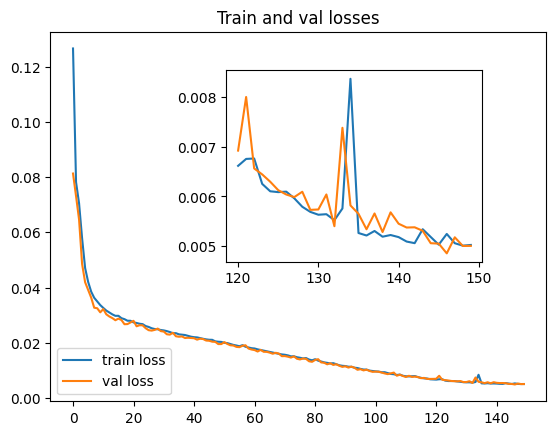

In [11]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['loss'][int(0.8*len(history['loss'])):],label='train loss')
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['val_loss'][int(0.8*len(history['loss'])):],label='val loss')
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

Text(0.5, 1.0, 'Train and val Accs')

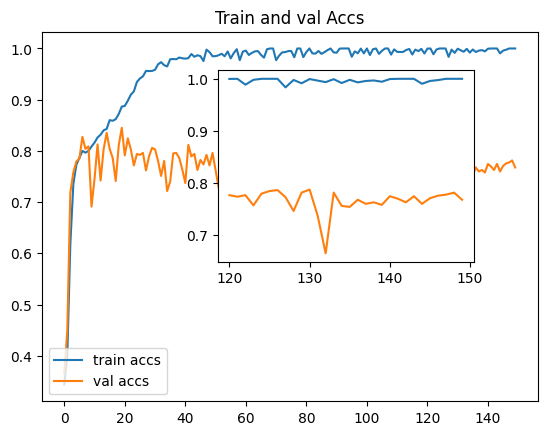

In [12]:
plot, axes = plt.subplots()
axes.plot(history['accs'],label='train accs')
axes.plot(history['val_accs'],label='val accs')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['accs'][int(0.8*len(history['loss'])):],label='train accs')
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['val_accs'][int(0.8*len(history['loss'])):],label='val accs')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val Accs')

### Loading the best performing model

In [13]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
alpha_delta_model.load_state_dict(best_delta_weights)
print(best_val_loss)

0.004853933368234292


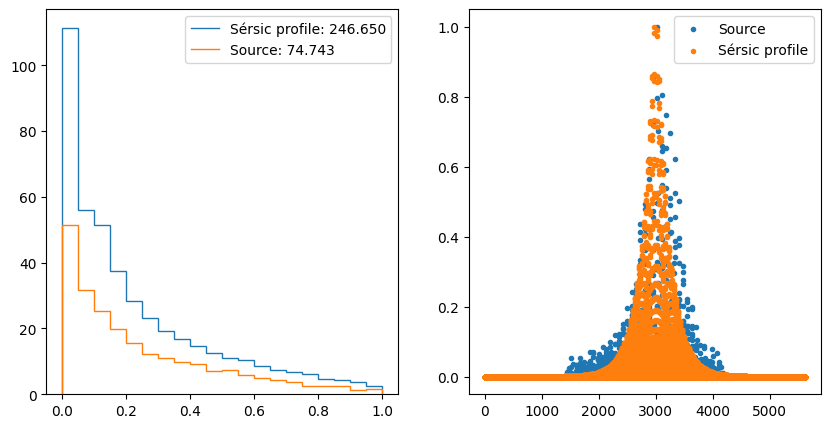

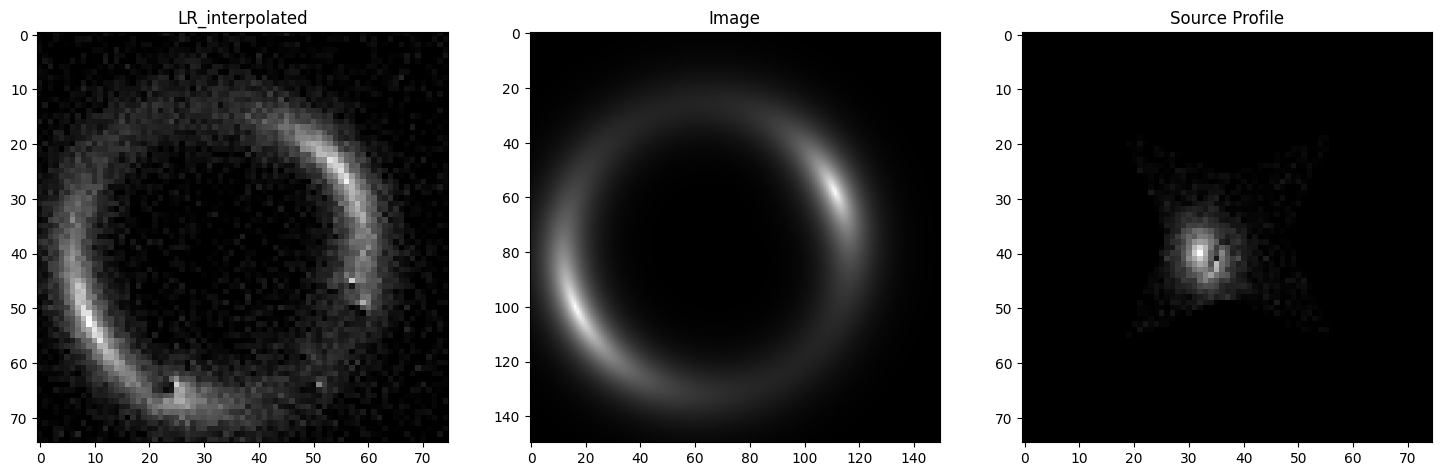

In [14]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [15]:
torch.save(best_weights, 'Weights_1.pt')
torch.save(best_delta_weights, 'Delta_1.pt')